In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile
import os
from urllib.parse import urljoin
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def baixar_shapefile_ibge():
    """
    Baixa o shapefile de municípios do IBGE
    """
    # URL do shapefile de municípios do IBGE (2022)
    url = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_Municipios_2022.zip"
    
    # Nome do arquivo local
    nome_arquivo = "BR_Municipios_2022.zip"
    pasta_dados = "dados_ibge"
    
    # Criar pasta se não existir
    if not os.path.exists(pasta_dados):
        os.makedirs(pasta_dados)
    
    caminho_zip = os.path.join(pasta_dados, nome_arquivo)
    
    # Verificar se já foi baixado
    if not os.path.exists(caminho_zip):
        print("Baixando shapefile do IBGE...")
        response = requests.get(url)
        with open(caminho_zip, 'wb') as f:
            f.write(response.content)
        print("Download concluído!")
    
    # Extrair o arquivo zip
    pasta_extracao = os.path.join(pasta_dados, "municipios")
    if not os.path.exists(pasta_extracao):
        print("Extraindo arquivos...")
        with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
            zip_ref.extractall(pasta_extracao)
        print("Extração concluída!")
    
    # Encontrar o arquivo .shp
    for arquivo in os.listdir(pasta_extracao):
        if arquivo.endswith('.shp'):
            return os.path.join(pasta_extracao, arquivo)
    
    raise FileNotFoundError("Arquivo shapefile não encontrado")

def baixar_dados_populacao_censo():
    """
    Baixa os dados de população do Censo 2022 do IBGE
    """
    # URL da API do IBGE para dados de população por município (Censo 2022)
    # Tabela 4714 - População residente, por situação do domicílio
    url_api = "https://servicodados.ibge.gov.br/api/v3/agregados/4714/periodos/2022/variaveis/93?localidades=N6[all]"
    
    pasta_dados = "dados_ibge"
    if not os.path.exists(pasta_dados):
        os.makedirs(pasta_dados)
        
    arquivo_populacao = os.path.join(pasta_dados, "populacao_censo_2022.json")
    
    # Verificar se já foi baixado
    if not os.path.exists(arquivo_populacao):
        print("Baixando dados de população do Censo 2022...")
        try:
            response = requests.get(url_api, timeout=60)
            response.raise_for_status()
            
            # Verificar se a resposta tem conteúdo válido
            if response.text and len(response.text) > 100:
                # Salvar dados localmente
                with open(arquivo_populacao, 'w', encoding='utf-8') as f:
                    f.write(response.text)
                print("Dados de população baixados com sucesso!")
            else:
                raise ValueError("Resposta da API vazia ou inválida")
                
        except Exception as e:
            print(f"Erro ao baixar dados da API do IBGE: {e}")
            print("Usando dados de exemplo...")
            return criar_dados_populacao_exemplo()
    
    # Carregar e processar os dados
    try:
        import json
        with open(arquivo_populacao, 'r', encoding='utf-8') as f:
            dados_json = json.load(f)
        
        # Verificar se os dados são válidos
        if not dados_json or not isinstance(dados_json, list):
            raise ValueError("Dados JSON inválidos")
        
        # Processar dados da API do IBGE
        df_populacao = processar_dados_censo_api(dados_json)
        
        # Verificar se conseguimos dados suficientes
        if len(df_populacao) < 100:  # Esperamos pelo menos 100 municípios
            print(f"Poucos dados obtidos da API ({len(df_populacao)} municípios)")
            print("Usando dados de exemplo...")
            return criar_dados_populacao_exemplo()
            
        print(f"Dados de população carregados: {len(df_populacao)} municípios")
        return df_populacao
        
    except Exception as e:
        print(f"Erro ao processar dados do censo: {e}")
        print("Usando dados de exemplo...")
        return criar_dados_populacao_exemplo()

def processar_dados_censo_api(dados_json):
    """
    Processa os dados da API do IBGE para criar DataFrame
    """
    municipios_data = []
    
    try:
        # Navegar pela estrutura da API do IBGE
        if isinstance(dados_json, list) and len(dados_json) > 0:
            resultados = dados_json[0].get('resultados', [])
            if resultados and len(resultados) > 0:
                series = resultados[0].get('series', [])
                
                for item in series:
                    try:
                        localidade = item.get('localidade', {})
                        codigo_municipio = localidade.get('id')
                        nome_municipio = localidade.get('nome')
                        
                        # Pegar o valor da população
                        serie_data = item.get('serie', {})
                        valores = serie_data.get('2022')
                        
                        if codigo_municipio and nome_municipio and valores and valores != '-':
                            # Limpar e converter valor
                            populacao_str = str(valores).replace('.', '').replace(',', '').strip()
                            if populacao_str.isdigit():
                                populacao = int(populacao_str)
                                municipios_data.append({
                                    'codigo_municipio': codigo_municipio,
                                    'municipio': nome_municipio,
                                    'populacao': populacao
                                })
                    except (KeyError, ValueError, AttributeError) as e:
                        # Continuar mesmo se um município der erro
                        continue
        
        if not municipios_data:
            raise ValueError("Nenhum dado válido encontrado na resposta da API")
            
    except Exception as e:
        print(f"Erro ao processar dados da API: {e}")
        raise
    
    print(f"Processados {len(municipios_data)} municípios da API do IBGE")
    return pd.DataFrame(municipios_data)

def criar_dados_populacao_exemplo():
    """
    Cria dados de exemplo caso a API não funcione
    """
    print("Criando dados de exemplo de população...")
    
    # Dados aproximados das principais cidades brasileiras
    dados_exemplo = {
        'municipio': [
            'São Paulo', 'Rio de Janeiro', 'Brasília', 'Salvador', 'Fortaleza',
            'Belo Horizonte', 'Manaus', 'Curitiba', 'Recife', 'Goiânia',
            'Belém', 'Porto Alegre', 'Guarulhos', 'Campinas', 'São Luís',
            'São Gonçalo', 'Maceió', 'Duque de Caxias', 'Natal', 'Teresina',
            'Campo Grande', 'Nova Iguaçu', 'São Bernardo do Campo', 'João Pessoa',
            'Osasco', 'Santo André', 'Ribeirão Preto', 'Sorocaba', 'Contagem',
            'Aracaju', 'Feira de Santana', 'Cuiabá', 'Joinville', 'Aparecida de Goiânia',
            'Londrina', 'Juiz de Fora', 'Ananindeua', 'Niterói', 'Belford Roxo',
            'Caxias do Sul', 'Campos dos Goytacazes', 'São João de Meriti', 'Vila Velha',
            'Florianópolis', 'Santos', 'Ribeirão das Neves', 'Diadema', 'Jundiaí',
            'Carapicuíba', 'Olinda'
        ],
        'populacao': [
            12396372, 6775561, 3094325, 2886698, 2703391,
            2530701, 2063689, 1963726, 1661017, 1555626,
            1506420, 1492530, 1398778, 1223237, 1115932,
            1091737, 1025360, 924624, 896708, 871126,
            906092, 823302, 844483, 825796, 697886,
            721368, 711825, 695328, 668949, 672614,
            619609, 673756, 597658, 593987, 575377,
            573285, 535547, 515317, 510906, 517451,
            507548, 472906, 501325, 508826, 433565,
            452101, 424285, 423006, 400077, 393115
        ]
    }
    
    return pd.DataFrame(dados_exemplo)

def normalizar_nome_municipio(nome):
    """
    Normaliza nomes de municípios para facilitar o join
    """
    import unicodedata
    # Remove acentos
    nome = unicodedata.normalize('NFD', str(nome))
    nome = ''.join(c for c in nome if unicodedata.category(c) != 'Mn')
    # Converte para maiúsculo e remove espaços extras
    return nome.upper().strip()

def criar_mapa_populacao_municipios(usar_log_scale=True, colormap='plasma', figsize=(20, 16)):
    """
    Cria mapa do Brasil com população por município do Censo 2022
    
    Parâmetros:
    - usar_log_scale: usar escala logarítmica para melhor visualização
    - colormap: colormap do matplotlib
    - figsize: tamanho da figura
    """
    
    # Baixar dados de população
    df_populacao = baixar_dados_populacao_censo()
    
    # Baixar e carregar shapefile
    caminho_shapefile = baixar_shapefile_ibge()
    print("Carregando shapefile...")
    gdf_municipios = gpd.read_file(caminho_shapefile)
    
    # Preparar dados para join
    print("Preparando dados para junção...")
    
    # Normalizar nomes no shapefile
    gdf_municipios['NM_MUN_NORM'] = gdf_municipios['NM_MUN'].apply(normalizar_nome_municipio)
    
    # Normalizar nomes nos dados de população
    df_populacao['municipio_norm'] = df_populacao['municipio'].apply(normalizar_nome_municipio)
    
    # Fazer o join
    print("Realizando join dos dados...")
    gdf_final = gdf_municipios.merge(
        df_populacao, 
        left_on='NM_MUN_NORM', 
        right_on='municipio_norm', 
        how='left'
    )
    
    # Se o join por nome não funcionou bem, tentar por código
    if 'codigo_municipio' in df_populacao.columns and 'CD_MUN' in gdf_municipios.columns:
        print("Tentando join adicional por código de município...")
        # Criar join por código como fallback
        gdf_final2 = gdf_municipios.merge(
            df_populacao, 
            left_on='CD_MUN', 
            right_on='codigo_municipio', 
            how='left',
            suffixes=('', '_codigo')
        )
        
        # Verificar se a coluna foi criada corretamente
        if 'populacao_codigo' in gdf_final2.columns:
            # Combinar resultados (priorizar join por código)
            mask_sem_dados = gdf_final['populacao'].isna()
            mask_com_dados_codigo = gdf_final2['populacao_codigo'].notna()
            
            gdf_final.loc[mask_sem_dados & mask_com_dados_codigo, 'populacao'] = \
                gdf_final2.loc[mask_sem_dados & mask_com_dados_codigo, 'populacao_codigo']
            
            print(f"Join por código adicionou dados para mais {mask_com_dados_codigo.sum()} municípios")
    
    # Estatísticas do join
    municipios_com_dados = gdf_final['populacao'].notna().sum()
    total_municipios = len(gdf_final)
    print(f"Join realizado: {municipios_com_dados}/{total_municipios} municípios com dados de população")
    
    # Aplicar escala logarítmica se solicitado
    if usar_log_scale:
        gdf_final['pop_viz'] = np.log10(gdf_final['populacao'].fillna(1))
        label_colorbar = 'População (log10)'
        titulo = 'População por Município - Brasil (Censo 2022) - Escala Logarítmica'
    else:
        gdf_final['pop_viz'] = gdf_final['populacao']
        label_colorbar = 'População'
        titulo = 'População por Município - Brasil (Censo 2022)'
    
    # Criar o mapa
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plotar municípios sem dados (cinza claro)
    gdf_sem_dados = gdf_final[gdf_final['populacao'].isna()]
    if not gdf_sem_dados.empty:
        gdf_sem_dados.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.05)
    
    # Plotar municípios com dados
    gdf_com_dados = gdf_final[gdf_final['populacao'].notna()]
    if not gdf_com_dados.empty:
        im = gdf_com_dados.plot(
            ax=ax, 
            column='pop_viz', 
            cmap=colormap,
            edgecolor='white', 
            linewidth=0.05,
            legend=False
        )
        
        # Adicionar colorbar personalizada
        sm = plt.cm.ScalarMappable(
            cmap=colormap, 
            norm=plt.Normalize(vmin=gdf_com_dados['pop_viz'].min(), 
                              vmax=gdf_com_dados['pop_viz'].max())
        )
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=30, pad=0.02)
        
        if usar_log_scale:
            # Personalizar labels da colorbar para escala log
            cbar.set_label('População', rotation=270, labelpad=20)
            # Adicionar algumas marcações de referência
            ticks_log = [1, 2, 3, 4, 5, 6, 7]  # 10^1 a 10^7
            labels_pop = ['10', '100', '1K', '10K', '100K', '1M', '10M']
            
            # Filtrar apenas os ticks que estão no range dos dados
            min_val, max_val = gdf_com_dados['pop_viz'].min(), gdf_com_dados['pop_viz'].max()
            ticks_filtrados = [t for t in ticks_log if min_val <= t <= max_val]
            labels_filtrados = [labels_pop[i] for i, t in enumerate(ticks_log) if min_val <= t <= max_val]
            
            if ticks_filtrados:
                cbar.set_ticks(ticks_filtrados)
                cbar.set_ticklabels(labels_filtrados)
        else:
            cbar.set_label(label_colorbar, rotation=270, labelpad=20)
    
    # Configurar o mapa
    ax.set_title(titulo, fontsize=18, fontweight='bold', pad=30)
    ax.set_axis_off()
    
    # Adicionar texto informativo
    info_text = f"Dados: IBGE Censo 2022\nMunicípios com dados: {municipios_com_dados:,}/{total_municipios:,}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Ajustar layout
    plt.tight_layout()
    
    return fig, ax, gdf_final, df_populacao

# Função para mostrar estatísticas
def mostrar_estatisticas_populacao(gdf_final):
    """
    Mostra estatísticas da população
    """
    dados_validos = gdf_final['populacao'].dropna()
    
    print("\n" + "="*50)
    print("ESTATÍSTICAS DE POPULAÇÃO - CENSO 2022")
    print("="*50)
    print(f"Total de municípios: {len(gdf_final):,}")
    print(f"Municípios com dados: {len(dados_validos):,}")
    print(f"População total: {dados_validos.sum():,} habitantes")
    print(f"População média por município: {dados_validos.mean():.0f} habitantes")
    print(f"População mediana: {dados_validos.median():.0f} habitantes")
    print(f"Menor município: {dados_validos.min():,} habitantes")
    print(f"Maior município: {dados_validos.max():,} habitantes")
    
    # Top 10 municípios mais populosos
    print(f"\nTOP 10 MUNICÍPIOS MAIS POPULOSOS:")
    print("-" * 40)
    top_10 = gdf_final.nlargest(10, 'populacao')[['NM_MUN', 'SIGLA_UF', 'populacao']]
    for idx, row in top_10.iterrows():
        print(f"{row['NM_MUN']}/{row['SIGLA_UF']}: {row['populacao']:,} hab")


In [5]:
df_populacao = baixar_dados_populacao_censo()

Processados 5570 municípios da API do IBGE
Dados de população carregados: 5570 municípios


In [23]:
print(df_populacao.head(10).to_markdown())

|    |   codigo_municipio | municipio                  |   populacao |
|---:|-------------------:|:---------------------------|------------:|
|  0 |            1100015 | Alta Floresta D'Oeste - RO |       21494 |
|  1 |            1100023 | Ariquemes - RO             |       96833 |
|  2 |            1100031 | Cabixi - RO                |        5351 |
|  3 |            1100049 | Cacoal - RO                |       86887 |
|  4 |            1100056 | Cerejeiras - RO            |       15890 |
|  5 |            1100064 | Colorado do Oeste - RO     |       15663 |
|  6 |            1100072 | Corumbiara - RO            |        7519 |
|  7 |            1100080 | Costa Marques - RO         |       12627 |
|  8 |            1100098 | Espigão D'Oeste - RO       |       29414 |
|  9 |            1100106 | Guajará-Mirim - RO         |       39387 |


In [11]:
# Baixar e carregar shapefile
caminho_shapefile = baixar_shapefile_ibge()
print("Carregando shapefile...")
gdf_municipios = gpd.read_file(caminho_shapefile)

Carregando shapefile...


In [13]:
gdf_municipios

CD_MUN                 NM_MUN SIGLA_UF  AREA_KM2  \
0     1100015  Alta Floresta D'Oeste       RO  7067.127   
1     1100023              Ariquemes       RO  4426.571   
2     1100031                 Cabixi       RO  1314.352   
3     1100049                 Cacoal       RO  3793.000   
4     1100056             Cerejeiras       RO  2783.300   
...       ...                    ...      ...       ...   
5567  5222005             Vianópolis       GO   954.115   
5568  5222054         Vicentinópolis       GO   733.794   
5569  5222203               Vila Boa       GO  1052.593   
5570  5222302          Vila Propício       GO  2181.593   
5571  5300108               Brasília       DF  5760.784   

                                               geometry  
0     POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...  
1     POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...  
2     POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...  
3     POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...  
4     POLYGON ((-60.82135 -13.1191, -60.81773 -13.12...  
...                                                 ...  
5567  POLYGON ((-48.31126 -16.84221, -48.3117 -16.84...  
5568  POLYGON ((-49.73613 -17.74427, -49.73624 -17.7...  
5569  POLYGON ((-47.0778 -15.06364, -47.07799 -15.06...  
5570  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...  
5571  POLYGON ((-48.01472 -16.04996, -48.01573 -16.0...  

[5572 rows x 5 columns]

Gerando mapa de população do Brasil por município...
Processados 5570 municípios da API do IBGE
Dados de população carregados: 5570 municípios
Carregando shapefile...
Preparando dados para junção...
Realizando join dos dados...
Tentando join adicional por código de município...
Join realizado: 0/5572 municípios com dados de população


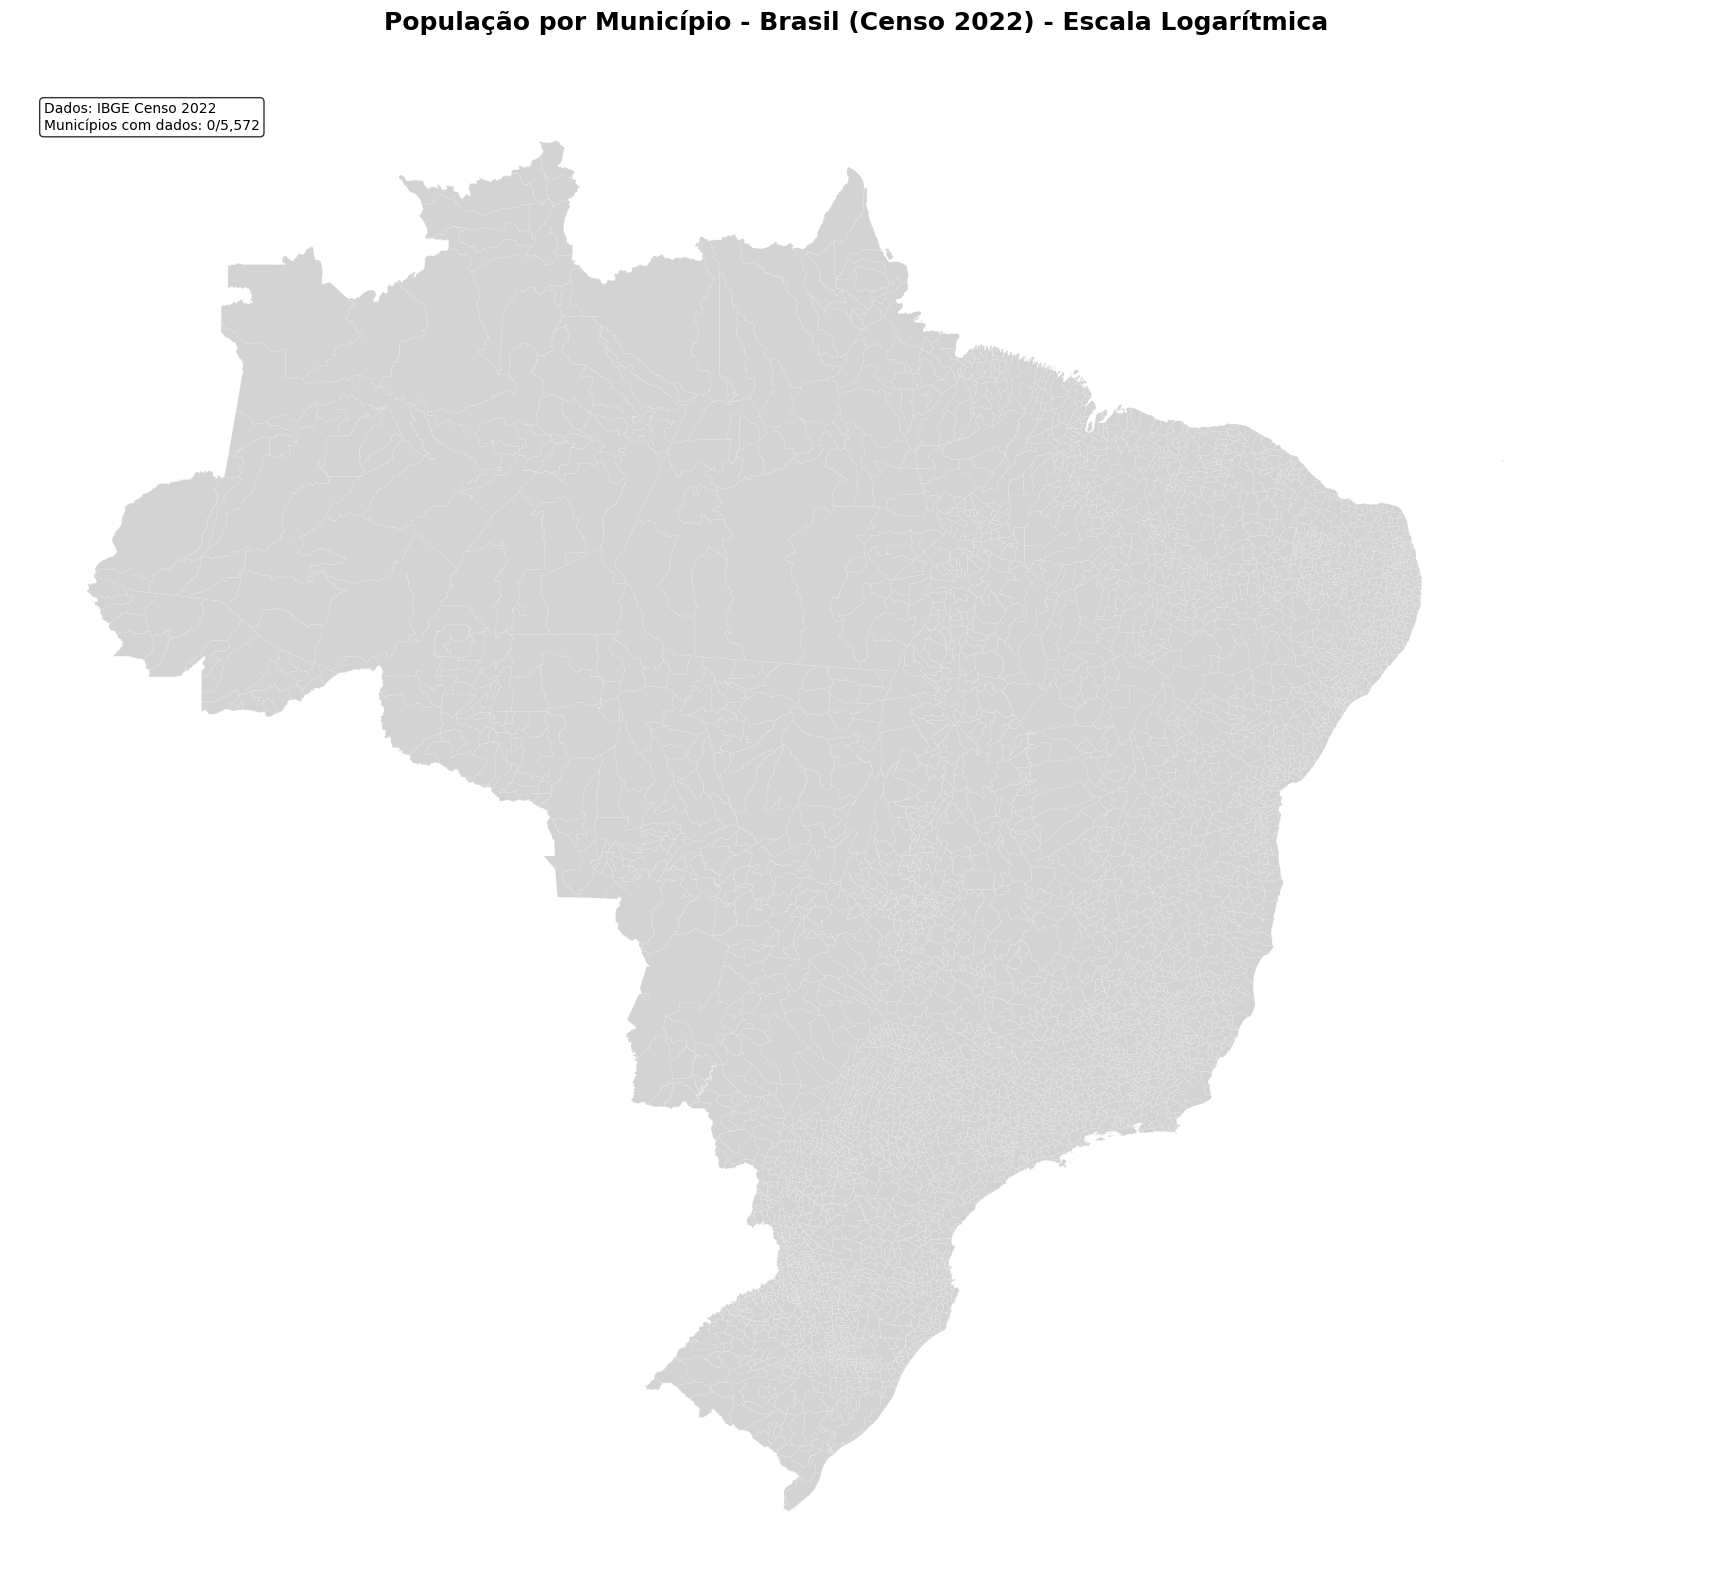

Mapa salvo como 'mapa_populacao_brasil_censo2022.png'

ESTATÍSTICAS DE POPULAÇÃO - CENSO 2022
Total de municípios: 5,572
Municípios com dados: 0
População total: 0.0 habitantes
População média por município: nan habitantes
População mediana: nan habitantes
Menor município: nan habitantes
Maior município: nan habitantes

TOP 10 MUNICÍPIOS MAIS POPULOSOS:
----------------------------------------
Alta Floresta D'Oeste/RO: nan hab
Ariquemes/RO: nan hab
Cabixi/RO: nan hab
Cacoal/RO: nan hab
Cerejeiras/RO: nan hab
Colorado do Oeste/RO: nan hab
Corumbiara/RO: nan hab
Costa Marques/RO: nan hab
Espigão D'Oeste/RO: nan hab
Guajará-Mirim/RO: nan hab

Gerando versão com escala linear...
Processados 5570 municípios da API do IBGE
Dados de população carregados: 5570 municípios
Carregando shapefile...
Preparando dados para junção...
Realizando join dos dados...
Tentando join adicional por código de município...
Join realizado: 0/5572 municípios com dados de população


KeyboardInterrupt: 

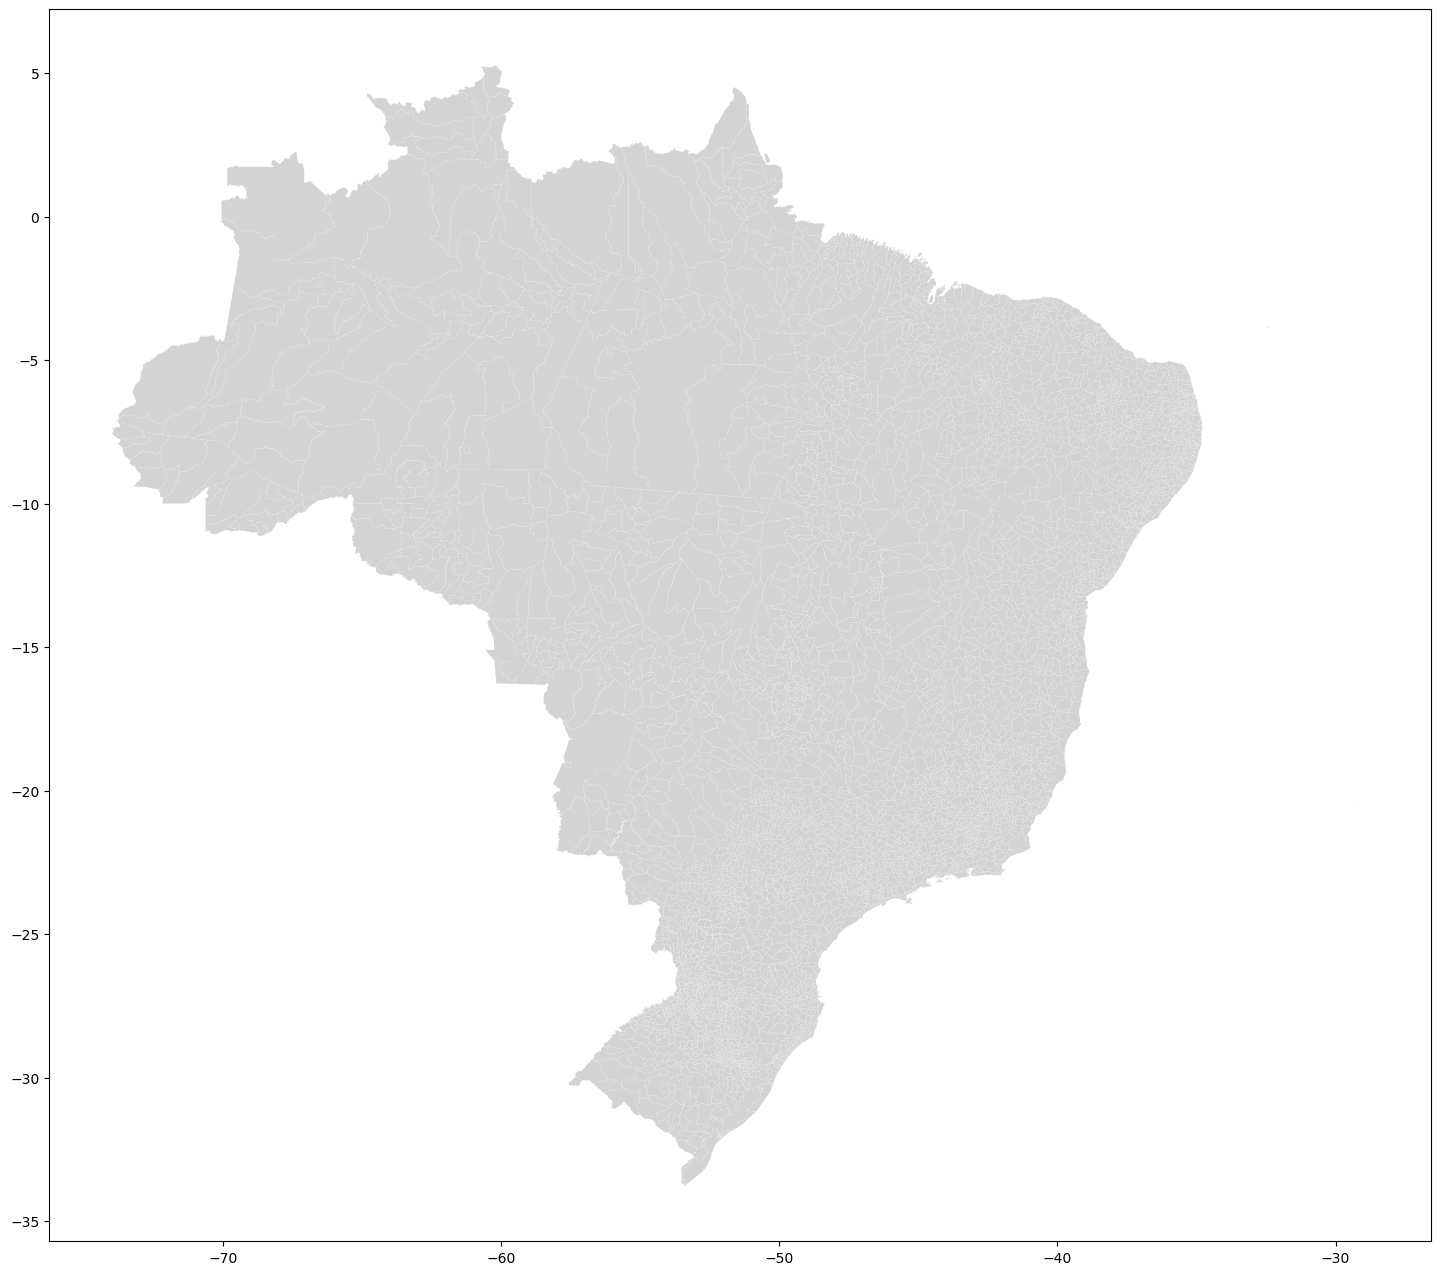

In [3]:

# Exemplo de uso princiapal
if __name__ == "__main__":
    # Criar mapa com escala logarítmica (recomendado para população)
    print("Gerando mapa de população do Brasil por município...")
    
    fig, ax, gdf_resultado, df_pop = criar_mapa_populacao_municipios(
        usar_log_scale=True,
        colormap='plasma',  # Boa opção: 'plasma', 'viridis', 'magma', 'inferno'
        figsize=(20, 16)
    )
    
    plt.show()
    
    # Salvar o mapa
    fig.savefig('mapa_populacao_brasil_censo2022.png', dpi=300, bbox_inches='tight')
    print("Mapa salvo como 'mapa_populacao_brasil_censo2022.png'")
    
    # Mostrar estatísticas
    mostrar_estatisticas_populacao(gdf_resultado)
    
    # Opcional: criar versão com escala linear também
    print("\nGerando versão com escala linear...")
    fig2, ax2, _, _ = criar_mapa_populacao_municipios(
        usar_log_scale=False,
        colormap='plasma',
        figsize=(20, 16)
    )
    
    fig2.savefig('mapa_populacao_brasil_censo2022_linear.png', dpi=300, bbox_inches='tight')
    print("Mapa com escala linear salvo como 'mapa_populacao_brasil_censo2022_linear.png'")
    
    # Salvar dados de população como CSV para futura referência
    df_pop.to_csv('dados_populacao_municipios_censo2022.csv', index=False, encoding='utf-8')
    print("Dados de população salvos como 'dados_populacao_municipios_censo2022.csv'")

Gerando mapa de população do Brasil por município...
Processados 5570 municípios da API do IBGE
Dados de população carregados: 5570 municípios
Carregando shapefile...
Preparando dados para junção...
Realizando join dos dados...
Tentando join por código de município...
Join por código: 5570 municípios encontrados
Join final: 5570/5572 municípios com dados de população

Exemplos de municípios sem dados (primeiros 10):
               NM_MUN SIGLA_UF   CD_MUN
4606      Lagoa Mirim       RS  4300001
4607  Lagoa dos Patos       RS  4300002

Exemplos dos dados de população (primeiros 5):
  codigo_municipio                   municipio
0          1100015  Alta Floresta D'Oeste - RO
1          1100023              Ariquemes - RO
2          1100031                 Cabixi - RO
3          1100049                 Cacoal - RO
4          1100056             Cerejeiras - RO

Códigos em comum: 5570 de 5570 códigos de população


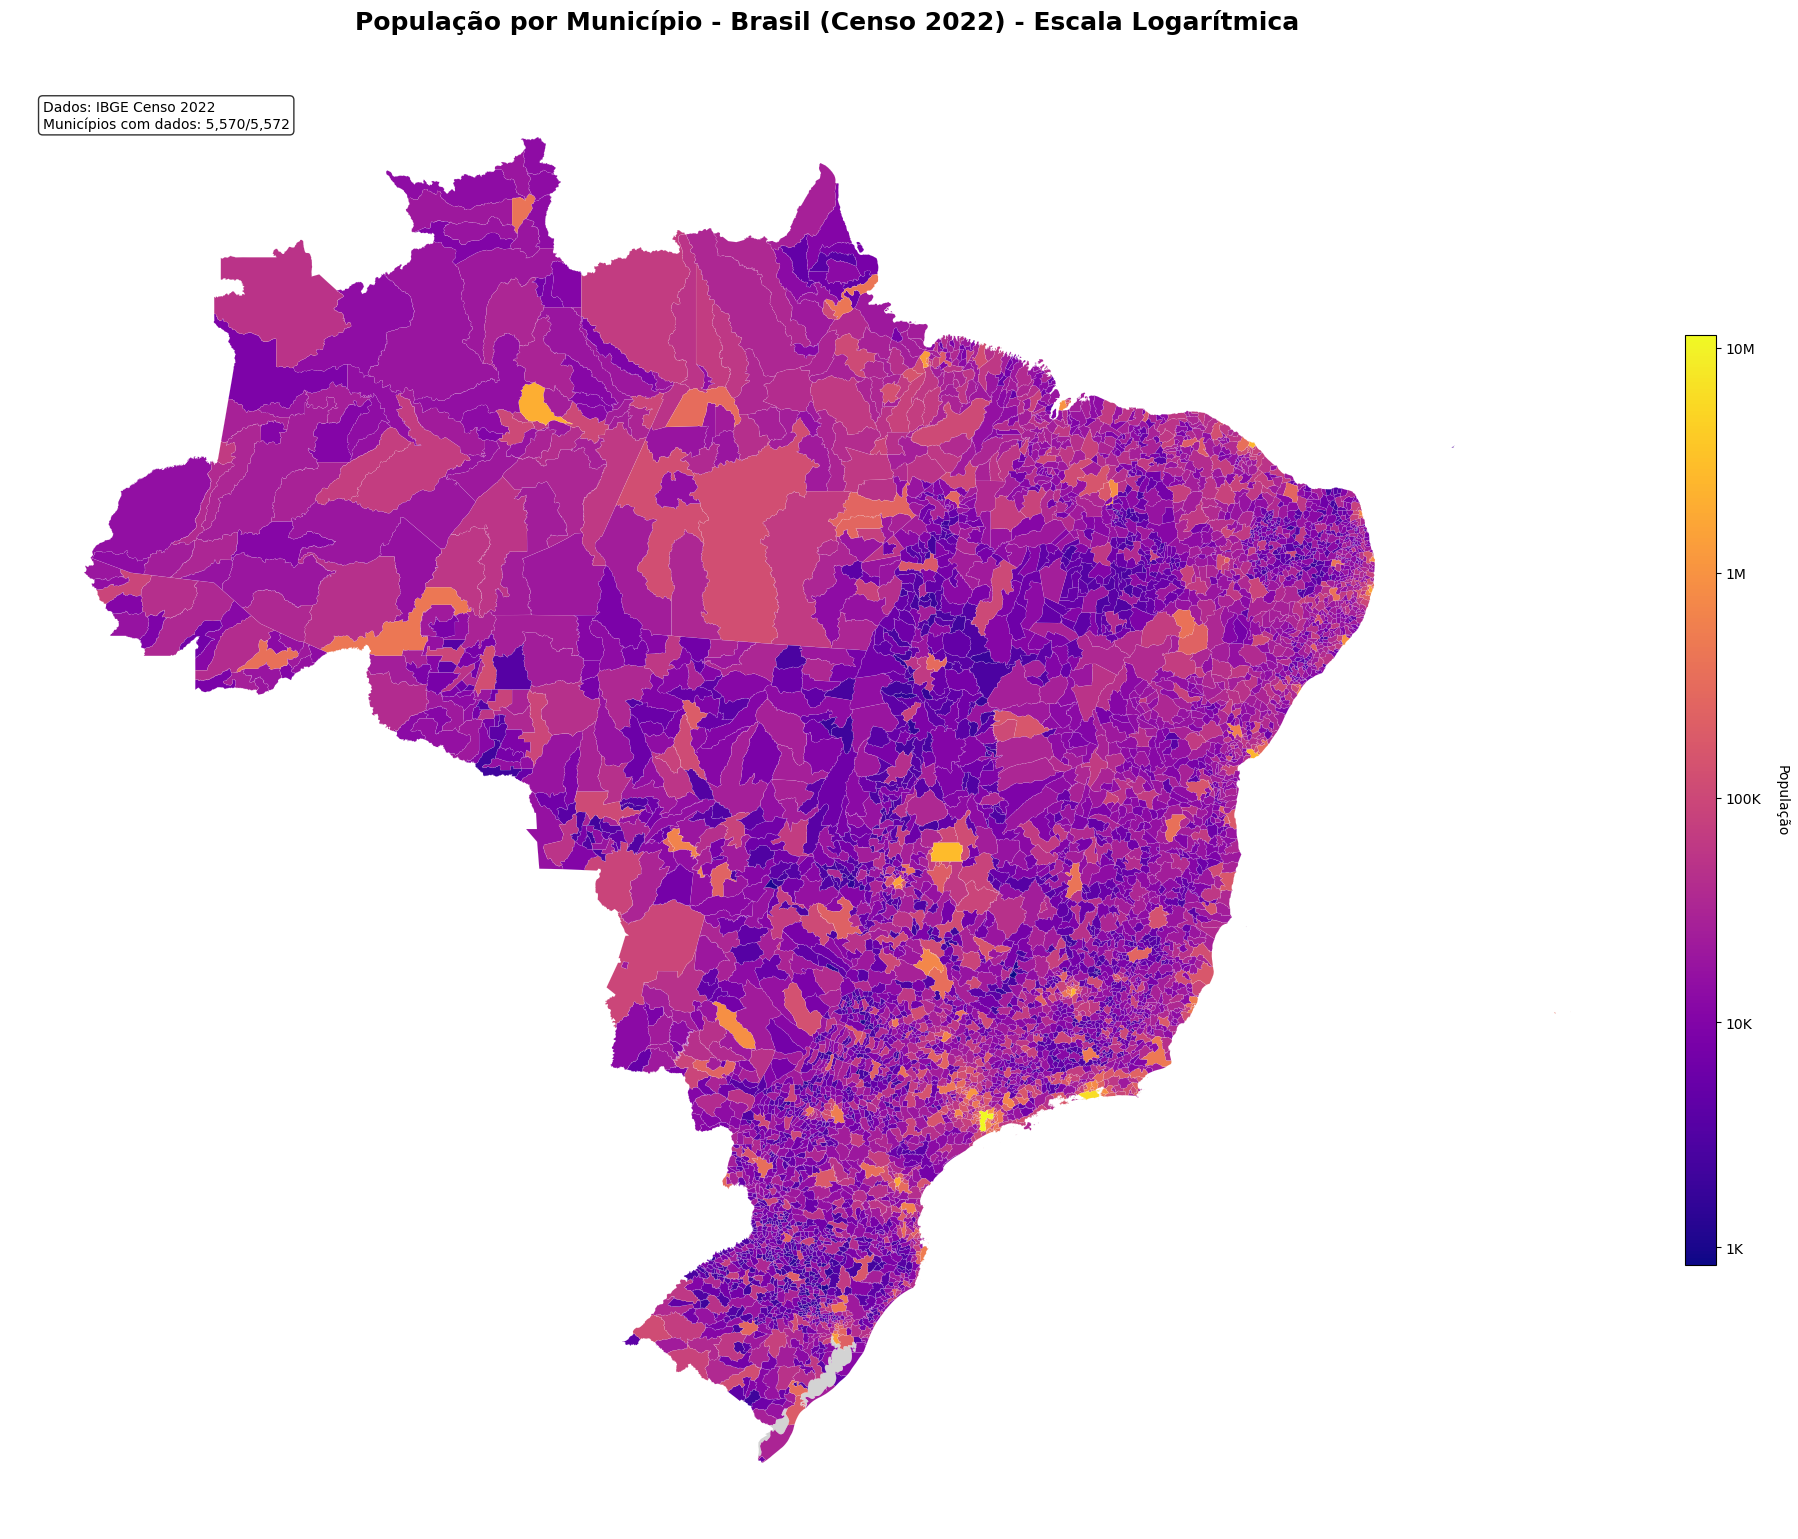

Mapa salvo como 'mapa_populacao_brasil_censo2022.png'

ESTATÍSTICAS DE POPULAÇÃO - CENSO 2022
Total de municípios: 5,572
Municípios com dados: 5,570
População total: 203,080,756.0 habitantes
População média por município: 36460 habitantes
População mediana: 11065 habitantes
Menor município: 833.0 habitantes
Maior município: 11,451,999.0 habitantes

TOP 10 MUNICÍPIOS MAIS POPULOSOS:
----------------------------------------
São Paulo/SP: 11,451,999.0 hab
Rio de Janeiro/RJ: 6,211,223.0 hab
Brasília/DF: 2,817,381.0 hab
Fortaleza/CE: 2,428,708.0 hab
Salvador/BA: 2,417,678.0 hab
Belo Horizonte/MG: 2,315,560.0 hab
Manaus/AM: 2,063,689.0 hab
Curitiba/PR: 1,773,718.0 hab
Recife/PE: 1,488,920.0 hab
Goiânia/GO: 1,437,366.0 hab

Gerando versão com escala linear...
Processados 5570 municípios da API do IBGE
Dados de população carregados: 5570 municípios
Carregando shapefile...
Preparando dados para junção...
Realizando join dos dados...
Tentando join por código de município...
Join por código: 5570

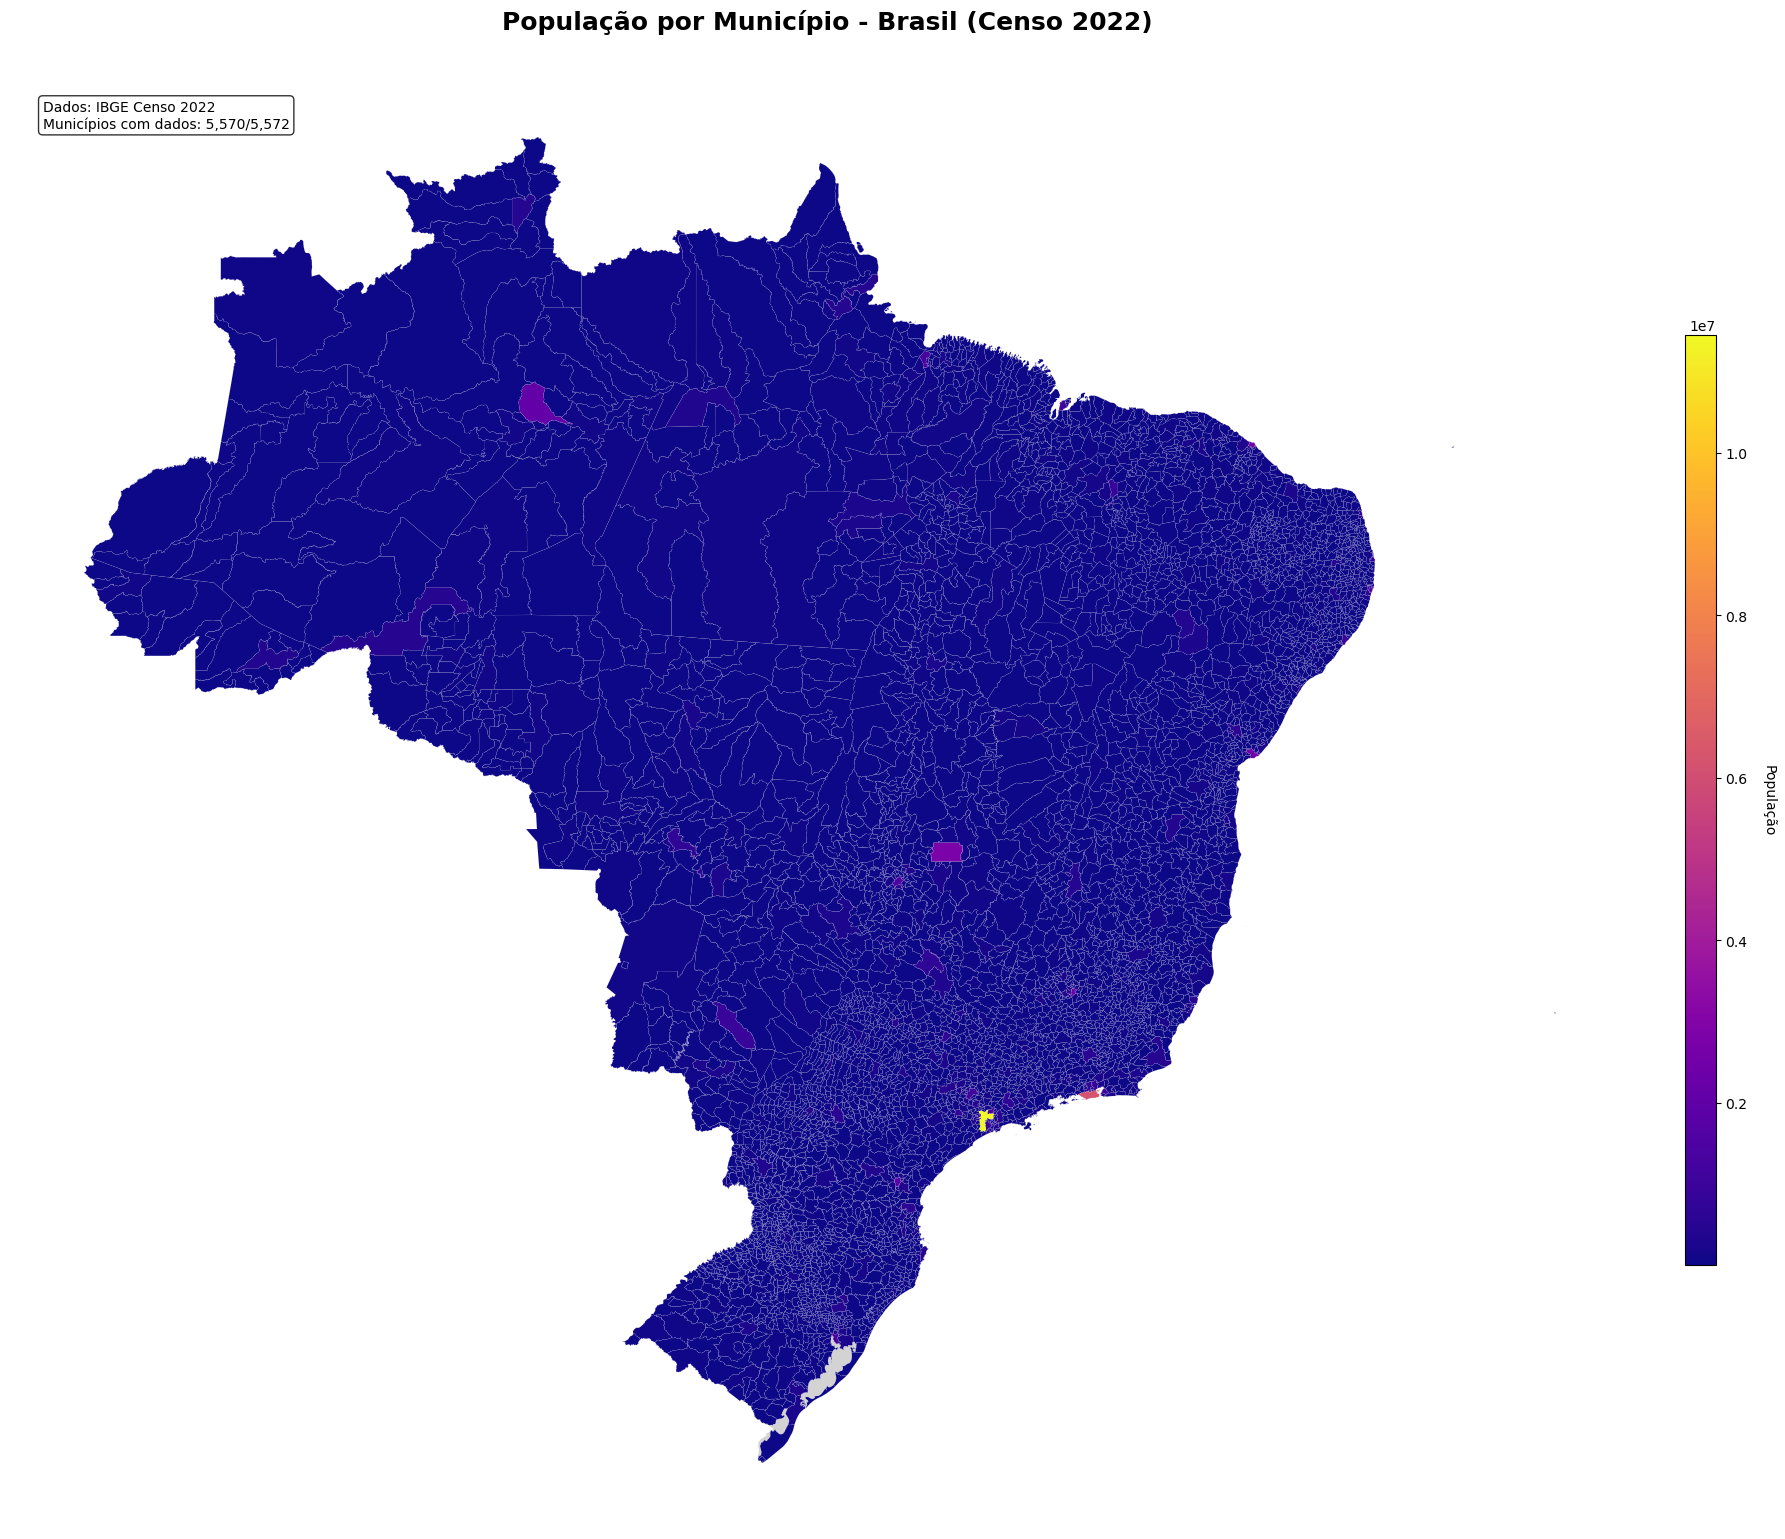

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile
import os
from urllib.parse import urljoin
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def baixar_shapefile_ibge():
    """
    Baixa o shapefile de municípios do IBGE
    """
    # URL do shapefile de municípios do IBGE (2022)
    url = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_Municipios_2022.zip"
    
    # Nome do arquivo local
    nome_arquivo = "BR_Municipios_2022.zip"
    pasta_dados = "dados_ibge"
    
    # Criar pasta se não existir
    if not os.path.exists(pasta_dados):
        os.makedirs(pasta_dados)
    
    caminho_zip = os.path.join(pasta_dados, nome_arquivo)
    
    # Verificar se já foi baixado
    if not os.path.exists(caminho_zip):
        print("Baixando shapefile do IBGE...")
        response = requests.get(url)
        with open(caminho_zip, 'wb') as f:
            f.write(response.content)
        print("Download concluído!")
    
    # Extrair o arquivo zip
    pasta_extracao = os.path.join(pasta_dados, "municipios")
    if not os.path.exists(pasta_extracao):
        print("Extraindo arquivos...")
        with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
            zip_ref.extractall(pasta_extracao)
        print("Extração concluída!")
    
    # Encontrar o arquivo .shp
    for arquivo in os.listdir(pasta_extracao):
        if arquivo.endswith('.shp'):
            return os.path.join(pasta_extracao, arquivo)
    
    raise FileNotFoundError("Arquivo shapefile não encontrado")

def baixar_dados_populacao_censo():
    """
    Baixa os dados de população do Censo 2022 do IBGE
    """
    # URL da API do IBGE para dados de população por município (Censo 2022)
    # Tabela 4714 - População residente, por situação do domicílio
    url_api = "https://servicodados.ibge.gov.br/api/v3/agregados/4714/periodos/2022/variaveis/93?localidades=N6[all]"
    
    pasta_dados = "dados_ibge"
    if not os.path.exists(pasta_dados):
        os.makedirs(pasta_dados)
        
    arquivo_populacao = os.path.join(pasta_dados, "populacao_censo_2022.json")
    
    # Verificar se já foi baixado
    if not os.path.exists(arquivo_populacao):
        print("Baixando dados de população do Censo 2022...")
        try:
            response = requests.get(url_api, timeout=60)
            response.raise_for_status()
            
            # Verificar se a resposta tem conteúdo válido
            if response.text and len(response.text) > 100:
                # Salvar dados localmente
                with open(arquivo_populacao, 'w', encoding='utf-8') as f:
                    f.write(response.text)
                print("Dados de população baixados com sucesso!")
            else:
                raise ValueError("Resposta da API vazia ou inválida")
                
        except Exception as e:
            print(f"Erro ao baixar dados da API do IBGE: {e}")
            print("Usando dados de exemplo...")
            return criar_dados_populacao_exemplo()
    
    # Carregar e processar os dados
    try:
        import json
        with open(arquivo_populacao, 'r', encoding='utf-8') as f:
            dados_json = json.load(f)
        
        # Verificar se os dados são válidos
        if not dados_json or not isinstance(dados_json, list):
            raise ValueError("Dados JSON inválidos")
        
        # Processar dados da API do IBGE
        df_populacao = processar_dados_censo_api(dados_json)
        
        # Verificar se conseguimos dados suficientes
        if len(df_populacao) < 100:  # Esperamos pelo menos 100 municípios
            print(f"Poucos dados obtidos da API ({len(df_populacao)} municípios)")
            print("Usando dados de exemplo...")
            return criar_dados_populacao_exemplo()
            
        print(f"Dados de população carregados: {len(df_populacao)} municípios")
        return df_populacao
        
    except Exception as e:
        print(f"Erro ao processar dados do censo: {e}")
        print("Usando dados de exemplo...")
        return criar_dados_populacao_exemplo()

def processar_dados_censo_api(dados_json):
    """
    Processa os dados da API do IBGE para criar DataFrame
    """
    municipios_data = []
    
    try:
        # Navegar pela estrutura da API do IBGE
        if isinstance(dados_json, list) and len(dados_json) > 0:
            resultados = dados_json[0].get('resultados', [])
            if resultados and len(resultados) > 0:
                series = resultados[0].get('series', [])
                
                for item in series:
                    try:
                        localidade = item.get('localidade', {})
                        codigo_municipio = localidade.get('id')
                        nome_municipio = localidade.get('nome')
                        
                        # Pegar o valor da população
                        serie_data = item.get('serie', {})
                        valores = serie_data.get('2022')
                        
                        if codigo_municipio and nome_municipio and valores and valores != '-':
                            # Limpar e converter valor
                            populacao_str = str(valores).replace('.', '').replace(',', '').strip()
                            if populacao_str.isdigit():
                                populacao = int(populacao_str)
                                municipios_data.append({
                                    'codigo_municipio': codigo_municipio,
                                    'municipio': nome_municipio,
                                    'populacao': populacao
                                })
                    except (KeyError, ValueError, AttributeError) as e:
                        # Continuar mesmo se um município der erro
                        continue
        
        if not municipios_data:
            raise ValueError("Nenhum dado válido encontrado na resposta da API")
            
    except Exception as e:
        print(f"Erro ao processar dados da API: {e}")
        raise
    
    print(f"Processados {len(municipios_data)} municípios da API do IBGE")
    return pd.DataFrame(municipios_data)

def criar_dados_populacao_exemplo():
    """
    Cria dados de exemplo caso a API não funcione
    """
    print("Criando dados de exemplo de população...")
    
    # Dados aproximados das principais cidades brasileiras
    dados_exemplo = {
        'municipio': [
            'São Paulo', 'Rio de Janeiro', 'Brasília', 'Salvador', 'Fortaleza',
            'Belo Horizonte', 'Manaus', 'Curitiba', 'Recife', 'Goiânia',
            'Belém', 'Porto Alegre', 'Guarulhos', 'Campinas', 'São Luís',
            'São Gonçalo', 'Maceió', 'Duque de Caxias', 'Natal', 'Teresina',
            'Campo Grande', 'Nova Iguaçu', 'São Bernardo do Campo', 'João Pessoa',
            'Osasco', 'Santo André', 'Ribeirão Preto', 'Sorocaba', 'Contagem',
            'Aracaju', 'Feira de Santana', 'Cuiabá', 'Joinville', 'Aparecida de Goiânia',
            'Londrina', 'Juiz de Fora', 'Ananindeua', 'Niterói', 'Belford Roxo',
            'Caxias do Sul', 'Campos dos Goytacazes', 'São João de Meriti', 'Vila Velha',
            'Florianópolis', 'Santos', 'Ribeirão das Neves', 'Diadema', 'Jundiaí',
            'Carapicuíba', 'Olinda'
        ],
        'populacao': [
            12396372, 6775561, 3094325, 2886698, 2703391,
            2530701, 2063689, 1963726, 1661017, 1555626,
            1506420, 1492530, 1398778, 1223237, 1115932,
            1091737, 1025360, 924624, 896708, 871126,
            906092, 823302, 844483, 825796, 697886,
            721368, 711825, 695328, 668949, 672614,
            619609, 673756, 597658, 593987, 575377,
            573285, 535547, 515317, 510906, 517451,
            507548, 472906, 501325, 508826, 433565,
            452101, 424285, 423006, 400077, 393115
        ]
    }
    
    return pd.DataFrame(dados_exemplo)

def normalizar_nome_municipio(nome):
    """
    Normaliza nomes de municípios para facilitar o join
    """
    import unicodedata
    # Remove acentos
    nome = unicodedata.normalize('NFD', str(nome))
    nome = ''.join(c for c in nome if unicodedata.category(c) != 'Mn')
    # Converte para maiúsculo e remove espaços extras
    nome = nome.upper().strip()
    
    # Se tem " - UF" no final, remove (para dados da API do IBGE)
    if ' - ' in nome:
        nome = nome.split(' - ')[0].strip()
    
    return nome

def criar_mapa_populacao_municipios(usar_log_scale=True, colormap='plasma', figsize=(20, 16)):
    """
    Cria mapa do Brasil com população por município do Censo 2022
    
    Parâmetros:
    - usar_log_scale: usar escala logarítmica para melhor visualização
    - colormap: colormap do matplotlib
    - figsize: tamanho da figura
    """
    
    # Baixar dados de população
    df_populacao = baixar_dados_populacao_censo()
    
    # Baixar e carregar shapefile
    caminho_shapefile = baixar_shapefile_ibge()
    print("Carregando shapefile...")
    gdf_municipios = gpd.read_file(caminho_shapefile)
    
    # Preparar dados para join
    print("Preparando dados para junção...")
    
    # Normalizar nomes no shapefile
    gdf_municipios['NM_MUN_NORM'] = gdf_municipios['NM_MUN'].apply(normalizar_nome_municipio)
    
    # Normalizar nomes nos dados de população
    df_populacao['municipio_norm'] = df_populacao['municipio'].apply(normalizar_nome_municipio)
    
    # Garantir que códigos estejam no mesmo formato (string)
    if 'CD_MUN' in gdf_municipios.columns:
        gdf_municipios['CD_MUN'] = gdf_municipios['CD_MUN'].astype(str)
    if 'codigo_municipio' in df_populacao.columns:
        df_populacao['codigo_municipio'] = df_populacao['codigo_municipio'].astype(str)
    
    # Fazer o join
    print("Realizando join dos dados...")
    
    # Primeiro, tentar join por código de município (mais confiável)
    if 'codigo_municipio' in df_populacao.columns and 'CD_MUN' in gdf_municipios.columns:
        print("Tentando join por código de município...")
        gdf_final = gdf_municipios.merge(
            df_populacao, 
            left_on='CD_MUN', 
            right_on='codigo_municipio', 
            how='left'
        )
        municipios_com_dados_codigo = gdf_final['populacao'].notna().sum()
        print(f"Join por código: {municipios_com_dados_codigo} municípios encontrados")
    else:
        gdf_final = gdf_municipios.copy()
        gdf_final['populacao'] = None
        municipios_com_dados_codigo = 0
    
    # Se ainda temos muitos municípios sem dados, tentar join por nome como complemento
    municipios_sem_dados = gdf_final['populacao'].isna().sum()
    if municipios_sem_dados > 1000:  # Se ainda faltam muitos dados
        print(f"Tentando join adicional por nome para {municipios_sem_dados} municípios restantes...")
        
        # Fazer join por nome para os municípios que ainda não têm dados
        gdf_sem_dados = gdf_final[gdf_final['populacao'].isna()].copy()
        
        df_join_nome = gdf_sem_dados.merge(
            df_populacao, 
            left_on='NM_MUN_NORM', 
            right_on='municipio_norm', 
            how='left',
            suffixes=('', '_nome')
        )
        
        # Atualizar dados onde conseguimos match por nome
        mask_nome_encontrado = df_join_nome['populacao_nome'].notna()
        if mask_nome_encontrado.any():
            indices_para_atualizar = gdf_sem_dados.index[mask_nome_encontrado]
            gdf_final.loc[indices_para_atualizar, 'populacao'] = df_join_nome.loc[mask_nome_encontrado, 'populacao_nome'].values
            print(f"Join por nome adicionou dados para mais {mask_nome_encontrado.sum()} municípios")
    
    # Estatísticas do join
    municipios_com_dados = gdf_final['populacao'].notna().sum()
    total_municipios = len(gdf_final)
    print(f"Join final: {municipios_com_dados}/{total_municipios} municípios com dados de população")
    
    # Debug: mostrar alguns exemplos de municípios sem dados
    if municipios_com_dados < total_municipios:
        sem_dados = gdf_final[gdf_final['populacao'].isna()]
        print(f"\nExemplos de municípios sem dados (primeiros 10):")
        print(sem_dados[['NM_MUN', 'SIGLA_UF', 'CD_MUN']].head(10).to_string())
        
        # Verificar se há correspondências nos dados de população
        print(f"\nExemplos dos dados de população (primeiros 5):")
        print(df_populacao[['codigo_municipio', 'municipio']].head().to_string())
        
        # Verificar se códigos batem
        codigos_shapefile = set(gdf_municipios['CD_MUN'].astype(str))
        codigos_populacao = set(df_populacao['codigo_municipio'].astype(str))
        codigos_comuns = codigos_shapefile.intersection(codigos_populacao)
        print(f"\nCódigos em comum: {len(codigos_comuns)} de {len(codigos_populacao)} códigos de população")
    
    # Aplicar escala logarítmica se solicitado
    if usar_log_scale:
        gdf_final['pop_viz'] = np.log10(gdf_final['populacao'].fillna(1))
        label_colorbar = 'População (log10)'
        titulo = 'População por Município - Brasil (Censo 2022) - Escala Logarítmica'
    else:
        gdf_final['pop_viz'] = gdf_final['populacao']
        label_colorbar = 'População'
        titulo = 'População por Município - Brasil (Censo 2022)'
    
    # Criar o mapa
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plotar municípios sem dados (cinza claro)
    gdf_sem_dados = gdf_final[gdf_final['populacao'].isna()]
    if not gdf_sem_dados.empty:
        gdf_sem_dados.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.05)
    
    # Plotar municípios com dados
    gdf_com_dados = gdf_final[gdf_final['populacao'].notna()]
    if not gdf_com_dados.empty:
        im = gdf_com_dados.plot(
            ax=ax, 
            column='pop_viz', 
            cmap=colormap,
            edgecolor='white', 
            linewidth=0.05,
            legend=False
        )
        
        # Adicionar colorbar personalizada
        sm = plt.cm.ScalarMappable(
            cmap=colormap, 
            norm=plt.Normalize(vmin=gdf_com_dados['pop_viz'].min(), 
                              vmax=gdf_com_dados['pop_viz'].max())
        )
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=30, pad=0.02)
        
        if usar_log_scale:
            # Personalizar labels da colorbar para escala log
            cbar.set_label('População', rotation=270, labelpad=20)
            # Adicionar algumas marcações de referência
            ticks_log = [1, 2, 3, 4, 5, 6, 7]  # 10^1 a 10^7
            labels_pop = ['10', '100', '1K', '10K', '100K', '1M', '10M']
            
            # Filtrar apenas os ticks que estão no range dos dados
            min_val, max_val = gdf_com_dados['pop_viz'].min(), gdf_com_dados['pop_viz'].max()
            ticks_filtrados = [t for t in ticks_log if min_val <= t <= max_val]
            labels_filtrados = [labels_pop[i] for i, t in enumerate(ticks_log) if min_val <= t <= max_val]
            
            if ticks_filtrados:
                cbar.set_ticks(ticks_filtrados)
                cbar.set_ticklabels(labels_filtrados)
        else:
            cbar.set_label(label_colorbar, rotation=270, labelpad=20)
    
    # Configurar o mapa
    ax.set_title(titulo, fontsize=18, fontweight='bold', pad=30)
    ax.set_axis_off()
    
    # Adicionar texto informativo
    info_text = f"Dados: IBGE Censo 2022\nMunicípios com dados: {municipios_com_dados:,}/{total_municipios:,}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Ajustar layout
    plt.tight_layout()
    
    return fig, ax, gdf_final, df_populacao

# Função para mostrar estatísticas
def mostrar_estatisticas_populacao(gdf_final):
    """
    Mostra estatísticas da população
    """
    dados_validos = gdf_final['populacao'].dropna()
    
    print("\n" + "="*50)
    print("ESTATÍSTICAS DE POPULAÇÃO - CENSO 2022")
    print("="*50)
    print(f"Total de municípios: {len(gdf_final):,}")
    print(f"Municípios com dados: {len(dados_validos):,}")
    print(f"População total: {dados_validos.sum():,} habitantes")
    print(f"População média por município: {dados_validos.mean():.0f} habitantes")
    print(f"População mediana: {dados_validos.median():.0f} habitantes")
    print(f"Menor município: {dados_validos.min():,} habitantes")
    print(f"Maior município: {dados_validos.max():,} habitantes")
    
    # Top 10 municípios mais populosos
    print(f"\nTOP 10 MUNICÍPIOS MAIS POPULOSOS:")
    print("-" * 40)
    top_10 = gdf_final.nlargest(10, 'populacao')[['NM_MUN', 'SIGLA_UF', 'populacao']]
    for idx, row in top_10.iterrows():
        print(f"{row['NM_MUN']}/{row['SIGLA_UF']}: {row['populacao']:,} hab")

# Exemplo de uso principal
if __name__ == "__main__":
    # Criar mapa com escala logarítmica (recomendado para população)
    print("Gerando mapa de população do Brasil por município...")
    
    fig, ax, gdf_resultado, df_pop = criar_mapa_populacao_municipios(
        usar_log_scale=True,
        colormap='plasma',  # Boa opção: 'plasma', 'viridis', 'magma', 'inferno'
        figsize=(20, 16)
    )
    
    plt.show()
    
    # Salvar o mapa
    fig.savefig('mapa_populacao_brasil_censo2022.png', dpi=300, bbox_inches='tight')
    print("Mapa salvo como 'mapa_populacao_brasil_censo2022.png'")
    
    # Mostrar estatísticas
    mostrar_estatisticas_populacao(gdf_resultado)
    
    # Opcional: criar versão com escala linear também
    print("\nGerando versão com escala linear...")
    fig2, ax2, _, _ = criar_mapa_populacao_municipios(
        usar_log_scale=False,
        colormap='plasma',
        figsize=(20, 16)
    )
    
    fig2.savefig('mapa_populacao_brasil_censo2022_linear.png', dpi=300, bbox_inches='tight')
    print("Mapa com escala linear salvo como 'mapa_populacao_brasil_censo2022_linear.png'")
    
    # Salvar dados de população como CSV para futura referência
    df_pop.to_csv('dados_populacao_municipios_censo2022.csv', index=False, encoding='utf-8')
    print("Dados de população salvos como 'dados_populacao_municipios_censo2022.csv'")

# Com estados

Gerando mapa de população do Brasil por município...
Processados 5570 municípios da API do IBGE
Dados de população carregados: 5570 municípios
Carregando shapefile...
Baixando shapefile de estados do IBGE...
Download de estados concluído!
Extraindo arquivos de estados...
Extração de estados concluída!
Carregando shapefile de estados...
Preparando dados para junção...
Realizando join dos dados...
Tentando join por código de município...
Join por código: 5570 municípios encontrados
Join final: 5570/5572 municípios com dados de população

Exemplos de municípios sem dados (primeiros 10):
               NM_MUN SIGLA_UF   CD_MUN
4606      Lagoa Mirim       RS  4300001
4607  Lagoa dos Patos       RS  4300002

Exemplos dos dados de população (primeiros 5):
  codigo_municipio                   municipio
0          1100015  Alta Floresta D'Oeste - RO
1          1100023              Ariquemes - RO
2          1100031                 Cabixi - RO
3          1100049                 Cacoal - RO
4     

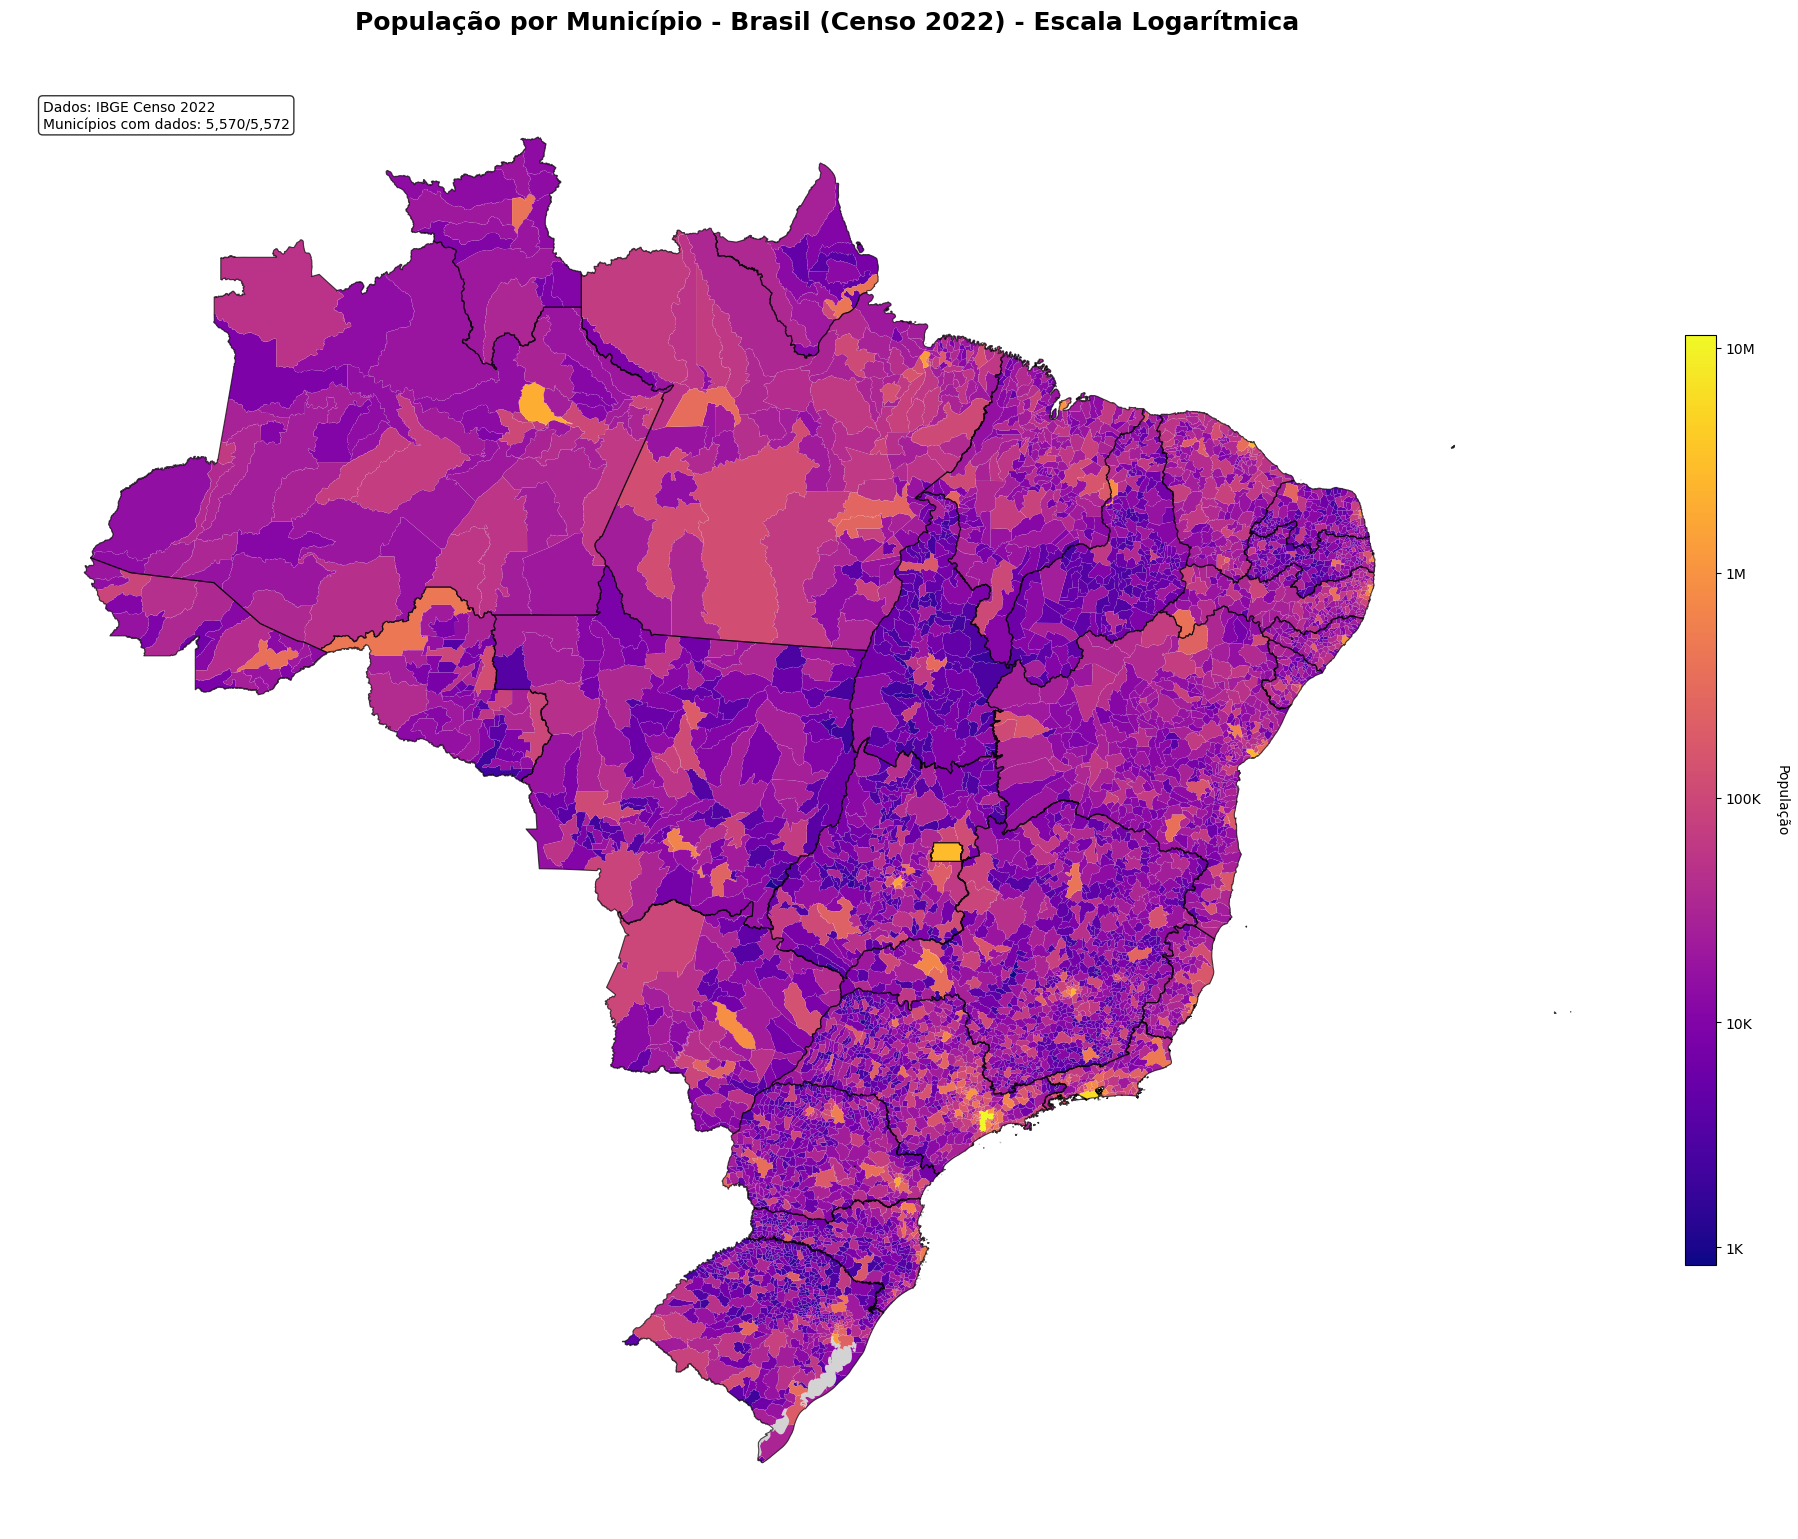

Mapa salvo como 'mapa_populacao_brasil_censo2022.png'

ESTATÍSTICAS DE POPULAÇÃO - CENSO 2022
Total de municípios: 5,572
Municípios com dados: 5,570
População total: 203,080,756.0 habitantes
População média por município: 36460 habitantes
População mediana: 11065 habitantes
Menor município: 833.0 habitantes
Maior município: 11,451,999.0 habitantes

TOP 10 MUNICÍPIOS MAIS POPULOSOS:
----------------------------------------
São Paulo/SP: 11,451,999.0 hab
Rio de Janeiro/RJ: 6,211,223.0 hab
Brasília/DF: 2,817,381.0 hab
Fortaleza/CE: 2,428,708.0 hab
Salvador/BA: 2,417,678.0 hab
Belo Horizonte/MG: 2,315,560.0 hab
Manaus/AM: 2,063,689.0 hab
Curitiba/PR: 1,773,718.0 hab
Recife/PE: 1,488,920.0 hab
Goiânia/GO: 1,437,366.0 hab

Gerando versão com escala linear...
Processados 5570 municípios da API do IBGE
Dados de população carregados: 5570 municípios
Carregando shapefile...
Carregando shapefile de estados...
Preparando dados para junção...
Realizando join dos dados...
Tentando join por código de

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile
import os
from urllib.parse import urljoin
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def baixar_shapefile_estados():
    """
    Baixa o shapefile de estados do IBGE
    """
    # URL do shapefile de estados do IBGE (2022)
    url = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_UF_2022.zip"
    
    # Nome do arquivo local
    nome_arquivo = "BR_UF_2022.zip"
    pasta_dados = "dados_ibge"
    
    # Criar pasta se não existir
    if not os.path.exists(pasta_dados):
        os.makedirs(pasta_dados)
    
    caminho_zip = os.path.join(pasta_dados, nome_arquivo)
    
    # Verificar se já foi baixado
    if not os.path.exists(caminho_zip):
        print("Baixando shapefile de estados do IBGE...")
        response = requests.get(url)
        with open(caminho_zip, 'wb') as f:
            f.write(response.content)
        print("Download de estados concluído!")
    
    # Extrair o arquivo zip
    pasta_extracao = os.path.join(pasta_dados, "estados")
    if not os.path.exists(pasta_extracao):
        print("Extraindo arquivos de estados...")
        with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
            zip_ref.extractall(pasta_extracao)
        print("Extração de estados concluída!")
    
    # Encontrar o arquivo .shp
    for arquivo in os.listdir(pasta_extracao):
        if arquivo.endswith('.shp'):
            return os.path.join(pasta_extracao, arquivo)
    
    raise FileNotFoundError("Arquivo shapefile de estados não encontrado")
    """
    Baixa o shapefile de municípios do IBGE
    """
def baixar_shapefile_ibge():
    """
    Baixa o shapefile de municípios do IBGE
    """
    # URL do shapefile de municípios do IBGE (2022)
    url = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_Municipios_2022.zip"
    
    # Nome do arquivo local
    nome_arquivo = "BR_Municipios_2022.zip"
    pasta_dados = "dados_ibge"
    
    # Criar pasta se não existir
    if not os.path.exists(pasta_dados):
        os.makedirs(pasta_dados)
    
    caminho_zip = os.path.join(pasta_dados, nome_arquivo)
    
    # Verificar se já foi baixado
    if not os.path.exists(caminho_zip):
        print("Baixando shapefile do IBGE...")
        response = requests.get(url)
        with open(caminho_zip, 'wb') as f:
            f.write(response.content)
        print("Download concluído!")
    
    # Extrair o arquivo zip
    pasta_extracao = os.path.join(pasta_dados, "municipios")
    if not os.path.exists(pasta_extracao):
        print("Extraindo arquivos...")
        with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
            zip_ref.extractall(pasta_extracao)
        print("Extração concluída!")
    
    # Encontrar o arquivo .shp
    for arquivo in os.listdir(pasta_extracao):
        if arquivo.endswith('.shp'):
            return os.path.join(pasta_extracao, arquivo)
    
    raise FileNotFoundError("Arquivo shapefile não encontrado")

def baixar_dados_populacao_censo():
    """
    Baixa os dados de população do Censo 2022 do IBGE
    """
    # URL da API do IBGE para dados de população por município (Censo 2022)
    # Tabela 4714 - População residente, por situação do domicílio
    url_api = "https://servicodados.ibge.gov.br/api/v3/agregados/4714/periodos/2022/variaveis/93?localidades=N6[all]"
    
    pasta_dados = "dados_ibge"
    if not os.path.exists(pasta_dados):
        os.makedirs(pasta_dados)
        
    arquivo_populacao = os.path.join(pasta_dados, "populacao_censo_2022.json")
    
    # Verificar se já foi baixado
    if not os.path.exists(arquivo_populacao):
        print("Baixando dados de população do Censo 2022...")
        try:
            response = requests.get(url_api, timeout=60)
            response.raise_for_status()
            
            # Verificar se a resposta tem conteúdo válido
            if response.text and len(response.text) > 100:
                # Salvar dados localmente
                with open(arquivo_populacao, 'w', encoding='utf-8') as f:
                    f.write(response.text)
                print("Dados de população baixados com sucesso!")
            else:
                raise ValueError("Resposta da API vazia ou inválida")
                
        except Exception as e:
            print(f"Erro ao baixar dados da API do IBGE: {e}")
            print("Usando dados de exemplo...")
            return criar_dados_populacao_exemplo()
    
    # Carregar e processar os dados
    try:
        import json
        with open(arquivo_populacao, 'r', encoding='utf-8') as f:
            dados_json = json.load(f)
        
        # Verificar se os dados são válidos
        if not dados_json or not isinstance(dados_json, list):
            raise ValueError("Dados JSON inválidos")
        
        # Processar dados da API do IBGE
        df_populacao = processar_dados_censo_api(dados_json)
        
        # Verificar se conseguimos dados suficientes
        if len(df_populacao) < 100:  # Esperamos pelo menos 100 municípios
            print(f"Poucos dados obtidos da API ({len(df_populacao)} municípios)")
            print("Usando dados de exemplo...")
            return criar_dados_populacao_exemplo()
            
        print(f"Dados de população carregados: {len(df_populacao)} municípios")
        return df_populacao
        
    except Exception as e:
        print(f"Erro ao processar dados do censo: {e}")
        print("Usando dados de exemplo...")
        return criar_dados_populacao_exemplo()

def processar_dados_censo_api(dados_json):
    """
    Processa os dados da API do IBGE para criar DataFrame
    """
    municipios_data = []
    
    try:
        # Navegar pela estrutura da API do IBGE
        if isinstance(dados_json, list) and len(dados_json) > 0:
            resultados = dados_json[0].get('resultados', [])
            if resultados and len(resultados) > 0:
                series = resultados[0].get('series', [])
                
                for item in series:
                    try:
                        localidade = item.get('localidade', {})
                        codigo_municipio = localidade.get('id')
                        nome_municipio = localidade.get('nome')
                        
                        # Pegar o valor da população
                        serie_data = item.get('serie', {})
                        valores = serie_data.get('2022')
                        
                        if codigo_municipio and nome_municipio and valores and valores != '-':
                            # Limpar e converter valor
                            populacao_str = str(valores).replace('.', '').replace(',', '').strip()
                            if populacao_str.isdigit():
                                populacao = int(populacao_str)
                                municipios_data.append({
                                    'codigo_municipio': codigo_municipio,
                                    'municipio': nome_municipio,
                                    'populacao': populacao
                                })
                    except (KeyError, ValueError, AttributeError) as e:
                        # Continuar mesmo se um município der erro
                        continue
        
        if not municipios_data:
            raise ValueError("Nenhum dado válido encontrado na resposta da API")
            
    except Exception as e:
        print(f"Erro ao processar dados da API: {e}")
        raise
    
    print(f"Processados {len(municipios_data)} municípios da API do IBGE")
    return pd.DataFrame(municipios_data)

def criar_dados_populacao_exemplo():
    """
    Cria dados de exemplo caso a API não funcione
    """
    print("Criando dados de exemplo de população...")
    
    # Dados aproximados das principais cidades brasileiras
    dados_exemplo = {
        'municipio': [
            'São Paulo', 'Rio de Janeiro', 'Brasília', 'Salvador', 'Fortaleza',
            'Belo Horizonte', 'Manaus', 'Curitiba', 'Recife', 'Goiânia',
            'Belém', 'Porto Alegre', 'Guarulhos', 'Campinas', 'São Luís',
            'São Gonçalo', 'Maceió', 'Duque de Caxias', 'Natal', 'Teresina',
            'Campo Grande', 'Nova Iguaçu', 'São Bernardo do Campo', 'João Pessoa',
            'Osasco', 'Santo André', 'Ribeirão Preto', 'Sorocaba', 'Contagem',
            'Aracaju', 'Feira de Santana', 'Cuiabá', 'Joinville', 'Aparecida de Goiânia',
            'Londrina', 'Juiz de Fora', 'Ananindeua', 'Niterói', 'Belford Roxo',
            'Caxias do Sul', 'Campos dos Goytacazes', 'São João de Meriti', 'Vila Velha',
            'Florianópolis', 'Santos', 'Ribeirão das Neves', 'Diadema', 'Jundiaí',
            'Carapicuíba', 'Olinda'
        ],
        'populacao': [
            12396372, 6775561, 3094325, 2886698, 2703391,
            2530701, 2063689, 1963726, 1661017, 1555626,
            1506420, 1492530, 1398778, 1223237, 1115932,
            1091737, 1025360, 924624, 896708, 871126,
            906092, 823302, 844483, 825796, 697886,
            721368, 711825, 695328, 668949, 672614,
            619609, 673756, 597658, 593987, 575377,
            573285, 535547, 515317, 510906, 517451,
            507548, 472906, 501325, 508826, 433565,
            452101, 424285, 423006, 400077, 393115
        ]
    }
    
    return pd.DataFrame(dados_exemplo)

def normalizar_nome_municipio(nome):
    """
    Normaliza nomes de municípios para facilitar o join
    """
    import unicodedata
    # Remove acentos
    nome = unicodedata.normalize('NFD', str(nome))
    nome = ''.join(c for c in nome if unicodedata.category(c) != 'Mn')
    # Converte para maiúsculo e remove espaços extras
    nome = nome.upper().strip()
    
    # Se tem " - UF" no final, remove (para dados da API do IBGE)
    if ' - ' in nome:
        nome = nome.split(' - ')[0].strip()
    
    return nome

def criar_mapa_populacao_municipios(usar_log_scale=True, colormap='plasma', figsize=(20, 16), 
                                   mostrar_divisoes_estados=True, mostrar_nomes_estados=False):
    """
    Cria mapa do Brasil com população por município do Censo 2022
    
    Parâmetros:
    - usar_log_scale: usar escala logarítmica para melhor visualização
    - colormap: colormap do matplotlib
    - figsize: tamanho da figura
    - mostrar_divisoes_estados: adicionar linhas de divisão entre estados
    - mostrar_nomes_estados: adicionar nomes dos estados no mapa
    """
    
    # Baixar dados de população
    df_populacao = baixar_dados_populacao_censo()
    
    # Baixar e carregar shapefile de municípios
    caminho_shapefile = baixar_shapefile_ibge()
    print("Carregando shapefile...")
    gdf_municipios = gpd.read_file(caminho_shapefile)
    
    # Baixar e carregar shapefile de estados se necessário
    gdf_estados = None
    if mostrar_divisoes_estados or mostrar_nomes_estados:
        try:
            caminho_shapefile_estados = baixar_shapefile_estados()
            print("Carregando shapefile de estados...")
            gdf_estados = gpd.read_file(caminho_shapefile_estados)
        except Exception as e:
            print(f"Erro ao carregar estados: {e}")
            print("Continuando sem divisões de estados...")
            mostrar_divisoes_estados = False
            mostrar_nomes_estados = False
    
    # Preparar dados para join
    print("Preparando dados para junção...")
    
    # Normalizar nomes no shapefile
    gdf_municipios['NM_MUN_NORM'] = gdf_municipios['NM_MUN'].apply(normalizar_nome_municipio)
    
    # Normalizar nomes nos dados de população
    df_populacao['municipio_norm'] = df_populacao['municipio'].apply(normalizar_nome_municipio)
    
    # Garantir que códigos estejam no mesmo formato (string)
    if 'CD_MUN' in gdf_municipios.columns:
        gdf_municipios['CD_MUN'] = gdf_municipios['CD_MUN'].astype(str)
    if 'codigo_municipio' in df_populacao.columns:
        df_populacao['codigo_municipio'] = df_populacao['codigo_municipio'].astype(str)
    
    # Fazer o join
    print("Realizando join dos dados...")
    
    # Primeiro, tentar join por código de município (mais confiável)
    if 'codigo_municipio' in df_populacao.columns and 'CD_MUN' in gdf_municipios.columns:
        print("Tentando join por código de município...")
        gdf_final = gdf_municipios.merge(
            df_populacao, 
            left_on='CD_MUN', 
            right_on='codigo_municipio', 
            how='left'
        )
        municipios_com_dados_codigo = gdf_final['populacao'].notna().sum()
        print(f"Join por código: {municipios_com_dados_codigo} municípios encontrados")
    else:
        gdf_final = gdf_municipios.copy()
        gdf_final['populacao'] = None
        municipios_com_dados_codigo = 0
    
    # Se ainda temos muitos municípios sem dados, tentar join por nome como complemento
    municipios_sem_dados = gdf_final['populacao'].isna().sum()
    if municipios_sem_dados > 1000:  # Se ainda faltam muitos dados
        print(f"Tentando join adicional por nome para {municipios_sem_dados} municípios restantes...")
        
        # Fazer join por nome para os municípios que ainda não têm dados
        gdf_sem_dados = gdf_final[gdf_final['populacao'].isna()].copy()
        
        df_join_nome = gdf_sem_dados.merge(
            df_populacao, 
            left_on='NM_MUN_NORM', 
            right_on='municipio_norm', 
            how='left',
            suffixes=('', '_nome')
        )
        
        # Atualizar dados onde conseguimos match por nome
        mask_nome_encontrado = df_join_nome['populacao_nome'].notna()
        if mask_nome_encontrado.any():
            indices_para_atualizar = gdf_sem_dados.index[mask_nome_encontrado]
            gdf_final.loc[indices_para_atualizar, 'populacao'] = df_join_nome.loc[mask_nome_encontrado, 'populacao_nome'].values
            print(f"Join por nome adicionou dados para mais {mask_nome_encontrado.sum()} municípios")
    
    # Estatísticas do join
    municipios_com_dados = gdf_final['populacao'].notna().sum()
    total_municipios = len(gdf_final)
    print(f"Join final: {municipios_com_dados}/{total_municipios} municípios com dados de população")
    
    # Debug: mostrar alguns exemplos de municípios sem dados
    if municipios_com_dados < total_municipios:
        sem_dados = gdf_final[gdf_final['populacao'].isna()]
        print(f"\nExemplos de municípios sem dados (primeiros 10):")
        print(sem_dados[['NM_MUN', 'SIGLA_UF', 'CD_MUN']].head(10).to_string())
        
        # Verificar se há correspondências nos dados de população
        print(f"\nExemplos dos dados de população (primeiros 5):")
        print(df_populacao[['codigo_municipio', 'municipio']].head().to_string())
        
        # Verificar se códigos batem
        codigos_shapefile = set(gdf_municipios['CD_MUN'].astype(str))
        codigos_populacao = set(df_populacao['codigo_municipio'].astype(str))
        codigos_comuns = codigos_shapefile.intersection(codigos_populacao)
        print(f"\nCódigos em comum: {len(codigos_comuns)} de {len(codigos_populacao)} códigos de população")
    
    # Aplicar escala logarítmica se solicitado
    if usar_log_scale:
        gdf_final['pop_viz'] = np.log10(gdf_final['populacao'].fillna(1))
        label_colorbar = 'População (log10)'
        titulo = 'População por Município - Brasil (Censo 2022) - Escala Logarítmica'
    else:
        gdf_final['pop_viz'] = gdf_final['populacao']
        label_colorbar = 'População'
        titulo = 'População por Município - Brasil (Censo 2022)'
    
    # Criar o mapa
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plotar municípios sem dados (cinza claro)
    gdf_sem_dados = gdf_final[gdf_final['populacao'].isna()]
    if not gdf_sem_dados.empty:
        gdf_sem_dados.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.05)
    
    # Plotar municípios com dados
    gdf_com_dados = gdf_final[gdf_final['populacao'].notna()]
    if not gdf_com_dados.empty:
        im = gdf_com_dados.plot(
            ax=ax, 
            column='pop_viz', 
            cmap=colormap,
            edgecolor='white', 
            linewidth=0.02,  # Bordas bem finas para municípios
            legend=False
        )
        
        # Adicionar colorbar personalizada
        sm = plt.cm.ScalarMappable(
            cmap=colormap, 
            norm=plt.Normalize(vmin=gdf_com_dados['pop_viz'].min(), 
                              vmax=gdf_com_dados['pop_viz'].max())
        )
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=30, pad=0.02)
        
        if usar_log_scale:
            # Personalizar labels da colorbar para escala log
            cbar.set_label('População', rotation=270, labelpad=20)
            # Adicionar algumas marcações de referência
            ticks_log = [1, 2, 3, 4, 5, 6, 7]  # 10^1 a 10^7
            labels_pop = ['10', '100', '1K', '10K', '100K', '1M', '10M']
            
            # Filtrar apenas os ticks que estão no range dos dados
            min_val, max_val = gdf_com_dados['pop_viz'].min(), gdf_com_dados['pop_viz'].max()
            ticks_filtrados = [t for t in ticks_log if min_val <= t <= max_val]
            labels_filtrados = [labels_pop[i] for i, t in enumerate(ticks_log) if min_val <= t <= max_val]
            
            if ticks_filtrados:
                cbar.set_ticks(ticks_filtrados)
                cbar.set_ticklabels(labels_filtrados)
        else:
            cbar.set_label(label_colorbar, rotation=270, labelpad=20)
    
    # Adicionar divisões dos estados
    if mostrar_divisoes_estados and gdf_estados is not None:
        print("Adicionando divisões dos estados...")
        gdf_estados.plot(ax=ax, 
                        facecolor='none',  # Sem preenchimento
                        edgecolor='black',  # Bordas pretas
                        linewidth=0.8,     # Linhas mais grossas que municípios
                        alpha=0.7)         # Ligeiramente transparente
    
    # Adicionar nomes dos estados
    if mostrar_nomes_estados and gdf_estados is not None:
        print("Adicionando nomes dos estados...")
        for idx, estado in gdf_estados.iterrows():
            # Calcular centroide do estado
            centroide = estado.geometry.centroid
            # Adicionar texto
            ax.annotate(estado['SIGLA_UF'], 
                       xy=(centroide.x, centroide.y),
                       xytext=(0, 0), textcoords="offset points",
                       ha='center', va='center',
                       fontsize=8, fontweight='bold',
                       color='darkred',
                       bbox=dict(boxstyle='round,pad=0.2', 
                               facecolor='white', 
                               edgecolor='darkred',
                               alpha=0.8))
    
    # Configurar o mapa
    ax.set_title(titulo, fontsize=18, fontweight='bold', pad=30)
    ax.set_axis_off()
    
    # Adicionar texto informativo
    info_text = f"Dados: IBGE Censo 2022\nMunicípios com dados: {municipios_com_dados:,}/{total_municipios:,}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Ajustar layout
    plt.tight_layout()
    
    return fig, ax, gdf_final, df_populacao

# Função para mostrar estatísticas
def mostrar_estatisticas_populacao(gdf_final):
    """
    Mostra estatísticas da população
    """
    dados_validos = gdf_final['populacao'].dropna()
    
    print("\n" + "="*50)
    print("ESTATÍSTICAS DE POPULAÇÃO - CENSO 2022")
    print("="*50)
    print(f"Total de municípios: {len(gdf_final):,}")
    print(f"Municípios com dados: {len(dados_validos):,}")
    print(f"População total: {dados_validos.sum():,} habitantes")
    print(f"População média por município: {dados_validos.mean():.0f} habitantes")
    print(f"População mediana: {dados_validos.median():.0f} habitantes")
    print(f"Menor município: {dados_validos.min():,} habitantes")
    print(f"Maior município: {dados_validos.max():,} habitantes")
    
    # Top 10 municípios mais populosos
    print(f"\nTOP 10 MUNICÍPIOS MAIS POPULOSOS:")
    print("-" * 40)
    top_10 = gdf_final.nlargest(10, 'populacao')[['NM_MUN', 'SIGLA_UF', 'populacao']]
    for idx, row in top_10.iterrows():
        print(f"{row['NM_MUN']}/{row['SIGLA_UF']}: {row['populacao']:,} hab")

# Exemplo de uso principal
if __name__ == "__main__":
    # Criar mapa com escala logarítmica (recomendado para população)
    print("Gerando mapa de população do Brasil por município...")
    
    fig, ax, gdf_resultado, df_pop = criar_mapa_populacao_municipios(
        usar_log_scale=True,
        colormap='plasma',  # Boa opção: 'plasma', 'viridis', 'magma', 'inferno'
        figsize=(20, 16),
        mostrar_divisoes_estados=True,  # Mostra linhas de divisão dos estados
        mostrar_nomes_estados=False     # Não mostra nomes (pode poluir o mapa)
    )
    
    plt.show()
    
    # Salvar o mapa
    fig.savefig('mapa_populacao_brasil_censo2022.png', dpi=300, bbox_inches='tight')
    print("Mapa salvo como 'mapa_populacao_brasil_censo2022.png'")
    
    # Mostrar estatísticas
    mostrar_estatisticas_populacao(gdf_resultado)
    
    # Opcional: criar versão com escala linear também
    print("\nGerando versão com escala linear...")
    fig2, ax2, _, _ = criar_mapa_populacao_municipios(
        usar_log_scale=False,
        colormap='plasma',
        figsize=(20, 16),
        mostrar_divisoes_estados=True,
        mostrar_nomes_estados=False
    )
    
    fig2.savefig('mapa_populacao_brasil_censo2022_linear.png', dpi=300, bbox_inches='tight')
    print("Mapa com escala linear salvo como 'mapa_populacao_brasil_censo2022_linear.png'")
    
    # Salvar dados de população como CSV para futura referência
    df_pop.to_csv('dados_populacao_municipios_censo2022.csv', index=False, encoding='utf-8')
    print("Dados de população salvos como 'dados_populacao_municipios_censo2022.csv'")